In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import pickle as pk

warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv('/kaggle/input/train-test-dataset/train_test_network.csv')
data.head()

,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
0,192.168.1.37,4444,192.168.1.193,49178,tcp,-,290.371539,101568,2592,OTH,...,0,0,-,-,-,-,-,-,1,backdoor
1,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000102,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
2,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000148,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
3,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000113,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
4,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000130,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor


In [3]:
data.tail()

,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
211038,192.168.1.32,48286,176.28.50.165,80,tcp,http,65.376610,2665,322,S3,...,0,0,-,-,-,-,-,-,1,xss
211039,192.168.1.32,48288,176.28.50.165,80,tcp,http,65.710346,1987,322,S3,...,0,0,-,-,-,-,-,-,1,xss
211040,192.168.1.32,48292,176.28.50.165,80,tcp,http,65.766512,3922,322,S3,...,0,0,-,-,-,-,-,-,1,xss
211041,192.168.1.32,48294,176.28.50.165,80,tcp,http,65.753940,2401,322,S3,...,0,0,-,-,-,-,-,-,1,xss
211042,192.168.1.32,48304,176.28.50.165,80,tcp,http,65.771855,3181,322,S3,...,0,0,-,-,-,-,-,-,1,xss


In [4]:
# count the distinct values on a column
data['label'].nunique()
#  check how many 0 values in label feature
data['label'].value_counts()

label
1    161043
0     50000
Name: count, dtype: int64

In [5]:
data['type'].nunique()
data['type'].value_counts()

type
normal        50000
backdoor      20000
ddos          20000
dos           20000
injection     20000
password      20000
scanning      20000
ransomware    20000
xss           20000
mitm           1043
Name: count, dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211043 entries, 0 to 211042
Data columns (total 44 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   src_ip                  211043 non-null  object 
 1   src_port                211043 non-null  int64  
 2   dst_ip                  211043 non-null  object 
 3   dst_port                211043 non-null  int64  
 4   proto                   211043 non-null  object 
 5   service                 211043 non-null  object 
 6   duration                211043 non-null  float64
 7   src_bytes               211043 non-null  int64  
 8   dst_bytes               211043 non-null  int64  
 9   conn_state              211043 non-null  object 
 10  missed_bytes            211043 non-null  int64  
 11  src_pkts                211043 non-null  int64  
 12  src_ip_bytes            211043 non-null  int64  
 13  dst_pkts                211043 non-null  int64  
 14  dst_ip_bytes        

In [7]:
# check how much values are null
data.isnull().sum()

src_ip                    0
src_port                  0
dst_ip                    0
dst_port                  0
proto                     0
service                   0
duration                  0
src_bytes                 0
dst_bytes                 0
conn_state                0
missed_bytes              0
src_pkts                  0
src_ip_bytes              0
dst_pkts                  0
dst_ip_bytes              0
dns_query                 0
dns_qclass                0
dns_qtype                 0
dns_rcode                 0
dns_AA                    0
dns_RD                    0
dns_RA                    0
dns_rejected              0
ssl_version               0
ssl_cipher                0
ssl_resumed               0
ssl_established           0
ssl_subject               0
ssl_issuer                0
http_trans_depth          0
http_method               0
http_uri                  0
http_version              0
http_request_body_len     0
http_response_body_len    0
http_status_code    

In [8]:
# check missing values
data.isna().sum()

src_ip                    0
src_port                  0
dst_ip                    0
dst_port                  0
proto                     0
service                   0
duration                  0
src_bytes                 0
dst_bytes                 0
conn_state                0
missed_bytes              0
src_pkts                  0
src_ip_bytes              0
dst_pkts                  0
dst_ip_bytes              0
dns_query                 0
dns_qclass                0
dns_qtype                 0
dns_rcode                 0
dns_AA                    0
dns_RD                    0
dns_RA                    0
dns_rejected              0
ssl_version               0
ssl_cipher                0
ssl_resumed               0
ssl_established           0
ssl_subject               0
ssl_issuer                0
http_trans_depth          0
http_method               0
http_uri                  0
http_version              0
http_request_body_len     0
http_response_body_len    0
http_status_code    

In [9]:
# select the used features from the dataset
selected_features = [
    'type',                 # target
    'src_ip',               # Source IP address
    'src_port',             # Source port number
    'dst_ip',               # Destination IP address
    'dst_port',             # Destination port number
    'proto',                # Network protocol (e.g., TCP, UDP)
    'service',              # Service type (e.g., HTTP, DNS)
    'duration',             # Duration of the connection
    'src_bytes',            # Bytes sent from source
    'dst_bytes',            # Bytes sent to destination
    'conn_state',           # Connection state (e.g., ESTABLISHED, SYN_SENT)
    'missed_bytes',         # Number of missed bytes
    'src_pkts',             # Source packet count
    'dst_pkts',             # Destination packet count
    'dns_query',            # DNS query information
    'dns_qtype',            # DNS query type
    'ssl_version',          # SSL version
    'ssl_cipher',           # SSL cipher used
    'http_method',          # HTTP method (e.g., GET, POST)
    'http_uri',             # Requested URI
    'http_status_code',     # HTTP status code (e.g., 200, 404)
    'weird_name',           # Weird network behaviors or events
    ]
data = data[selected_features]

In [10]:
data.head()

,type,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,...,src_pkts,dst_pkts,dns_query,dns_qtype,ssl_version,ssl_cipher,http_method,http_uri,http_status_code,weird_name
0,backdoor,192.168.1.37,4444,192.168.1.193,49178,tcp,-,290.371539,101568,2592,...,108,31,-,0,-,-,-,-,0,-
1,backdoor,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000102,0,0,...,1,1,-,0,-,-,-,-,0,-
2,backdoor,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000148,0,0,...,1,1,-,0,-,-,-,-,0,-
3,backdoor,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000113,0,0,...,1,1,-,0,-,-,-,-,0,-
4,backdoor,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000130,0,0,...,1,1,-,0,-,-,-,-,0,-


In [11]:
# select the categorical features
categorical_features = data.select_dtypes(include=['object']).columns
categorical_features

Index(['type', 'src_ip', 'dst_ip', 'proto', 'service', 'conn_state',
       'dns_query', 'ssl_version', 'ssl_cipher', 'http_method', 'http_uri',
       'weird_name'],
      dtype='object')

In [12]:
# mapping the target columns from [0 .. 9]
mapping = {
    'normal': 0,
    'backdoor': 1,
    'ddos': 2,
    'dos': 3,
    'injection': 4,
    'password': 5,
    'ransomware': 6,
    'scanning': 7,
    'xss': 8,
    'mitm': 9
}
data['type'] = data['type'].map(mapping)

In [13]:
data.head()

,type,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,...,src_pkts,dst_pkts,dns_query,dns_qtype,ssl_version,ssl_cipher,http_method,http_uri,http_status_code,weird_name
0,1,192.168.1.37,4444,192.168.1.193,49178,tcp,-,290.371539,101568,2592,...,108,31,-,0,-,-,-,-,0,-
1,1,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000102,0,0,...,1,1,-,0,-,-,-,-,0,-
2,1,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000148,0,0,...,1,1,-,0,-,-,-,-,0,-
3,1,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000113,0,0,...,1,1,-,0,-,-,-,-,0,-
4,1,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000130,0,0,...,1,1,-,0,-,-,-,-,0,-


In [14]:
data.tail()

,type,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,...,src_pkts,dst_pkts,dns_query,dns_qtype,ssl_version,ssl_cipher,http_method,http_uri,http_status_code,weird_name
211038,8,192.168.1.32,48286,176.28.50.165,80,tcp,http,65.376610,2665,322,...,5,5,-,0,-,-,-,-,0,-
211039,8,192.168.1.32,48288,176.28.50.165,80,tcp,http,65.710346,1987,322,...,6,5,-,0,-,-,-,-,0,-
211040,8,192.168.1.32,48292,176.28.50.165,80,tcp,http,65.766512,3922,322,...,7,6,-,0,-,-,-,-,0,-
211041,8,192.168.1.32,48294,176.28.50.165,80,tcp,http,65.753940,2401,322,...,6,5,-,0,-,-,-,-,0,-
211042,8,192.168.1.32,48304,176.28.50.165,80,tcp,http,65.771855,3181,322,...,7,6,-,0,-,-,-,-,0,-


In [15]:
# shuffle data
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,type,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,...,src_pkts,dst_pkts,dns_query,dns_qtype,ssl_version,ssl_cipher,http_method,http_uri,http_status_code,weird_name
0,7,192.168.1.31,58720,192.168.1.49,587,tcp,-,0.000000,0,0,...,1,0,-,0,-,-,-,-,0,-
1,0,192.168.1.190,1677,192.168.1.190,1677,tcp,-,0.215150,0,0,...,120,0,-,0,-,-,-,-,0,-
2,7,192.168.1.30,42908,192.168.1.152,27353,tcp,-,0.007178,0,0,...,1,1,-,0,-,-,-,-,0,-
3,5,192.168.1.30,33000,192.168.1.195,80,tcp,http,20.535570,3896,26489,...,25,41,-,0,-,-,-,-,0,-
4,3,192.168.1.30,57,192.168.1.193,57,tcp,-,0.000006,0,0,...,2,2,-,0,-,-,-,-,0,-


In [16]:
data.tail()

,type,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,...,src_pkts,dst_pkts,dns_query,dns_qtype,ssl_version,ssl_cipher,http_method,http_uri,http_status_code,weird_name
211038,0,192.168.1.6,5353,224.0.0.251,5353,udp,dns,0.000000,0,0,...,1,0,_googlecast._tcp.local,12,-,-,-,-,0,-
211039,8,192.168.1.32,39586,18.194.169.124,80,tcp,http,1.062314,3007,1523,...,6,5,-,0,-,-,-,-,0,-
211040,0,192.168.1.152,34296,192.168.1.152,10502,tcp,-,0.000000,0,0,...,0,0,-,0,-,-,-,-,0,-
211041,7,192.168.1.31,50948,192.168.1.133,2222,tcp,-,0.000000,0,0,...,1,0,-,0,-,-,-,-,0,-
211042,2,192.168.1.30,46732,192.168.1.184,443,tcp,-,0.000022,0,0,...,2,1,-,0,-,-,-,-,0,-


In [17]:
# print unique values for proto
data['proto'].unique()

array(['tcp', 'udp', 'icmp'], dtype=object)

In [18]:
# map proto values to 0 , 1 and 2
proto_mapping = {
    'tcp': 0,
    'udp': 1,
    'icmp': 2
}
data['proto'] = data['proto'].map(proto_mapping)
data.head()

,type,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,...,src_pkts,dst_pkts,dns_query,dns_qtype,ssl_version,ssl_cipher,http_method,http_uri,http_status_code,weird_name
0,7,192.168.1.31,58720,192.168.1.49,587,0,-,0.000000,0,0,...,1,0,-,0,-,-,-,-,0,-
1,0,192.168.1.190,1677,192.168.1.190,1677,0,-,0.215150,0,0,...,120,0,-,0,-,-,-,-,0,-
2,7,192.168.1.30,42908,192.168.1.152,27353,0,-,0.007178,0,0,...,1,1,-,0,-,-,-,-,0,-
3,5,192.168.1.30,33000,192.168.1.195,80,0,http,20.535570,3896,26489,...,25,41,-,0,-,-,-,-,0,-
4,3,192.168.1.30,57,192.168.1.193,57,0,-,0.000006,0,0,...,2,2,-,0,-,-,-,-,0,-


In [55]:
# label encoding for src_ip and dst_ip
le_src , le_dst = LabelEncoder() , LabelEncoder()
data['src_ip'] = le_src.fit_transform(data['src_ip'])
data['dst_ip'] = le_dst.fit_transform(data['dst_ip'])
data.head()

,type,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,...,src_pkts,dst_pkts,dns_query,dns_qtype,ssl_version,ssl_cipher,http_method,http_uri,http_status_code,weird_name
0,7.0,21,58720.0,212,587.0,0.0,0.0,0.000000,0.0,0.0,...,1.0,0.0,3.920578,0.0,3.462667,3.462667,0.0,3.459716,0.0,3.461917
1,0.0,13,1677.0,199,1677.0,0.0,0.0,0.215150,0.0,0.0,...,120.0,0.0,3.920578,0.0,3.462667,3.462667,0.0,3.459716,0.0,3.461917
2,7.0,20,42908.0,194,27353.0,0.0,0.0,0.007178,0.0,0.0,...,1.0,1.0,3.920578,0.0,3.462667,3.462667,0.0,3.459716,0.0,3.461917
3,5.0,20,33000.0,203,80.0,0.0,2.0,20.535570,3896.0,26489.0,...,25.0,41.0,3.920578,0.0,3.462667,3.462667,0.0,3.459716,0.0,3.461917
4,3.0,20,57.0,201,57.0,0.0,0.0,0.000006,0.0,0.0,...,2.0,2.0,3.920578,0.0,3.462667,3.462667,0.0,3.459716,0.0,3.461917


In [20]:
# count unique values of service
data['service'].nunique()

9

In [21]:
data['service'].unique()

array(['-', 'http', 'dns', 'ssl', 'smb', 'ftp', 'gssapi', 'dce_rpc',
       'smb;gssapi'], dtype=object)

In [22]:
# count how many "-"
data['service'].value_counts()

service
-             132032
dns            39446
http           37029
ftp             1065
ssl             1025
gssapi           184
dce_rpc          136
smb              108
smb;gssapi        18
Name: count, dtype: int64

In [23]:
# # replace "-" values with 0
# data['service'] = data['service'].replace('-', 0)
# data['service'].value_counts()

In [24]:
# map proto values to 0 , 1 and 2
proto_mapping = {
    '-': 0,
    'dns': 1,
    'http': 2,
    'ftp': 3,
    'ssl':4,
    'gssapi':5,
    'dce_rpc':6,
    'smb':7,
    'smb;gssapi	':8,
}
data['service'] = data['service'].map(proto_mapping)
data.head()

,type,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,...,src_pkts,dst_pkts,dns_query,dns_qtype,ssl_version,ssl_cipher,http_method,http_uri,http_status_code,weird_name
0,7,21,58720,212,587,0,0.0,0.000000,0,0,...,1,0,-,0,-,-,-,-,0,-
1,0,13,1677,199,1677,0,0.0,0.215150,0,0,...,120,0,-,0,-,-,-,-,0,-
2,7,20,42908,194,27353,0,0.0,0.007178,0,0,...,1,1,-,0,-,-,-,-,0,-
3,5,20,33000,203,80,0,2.0,20.535570,3896,26489,...,25,41,-,0,-,-,-,-,0,-
4,3,20,57,201,57,0,0.0,0.000006,0,0,...,2,2,-,0,-,-,-,-,0,-


In [25]:
!pip install --upgrade category_encoders

In [26]:
# apply category encoder for dns_query feature
import category_encoders as ce

#Specify the columns you want to encode
columns_to_encode = ['dns_query', 'ssl_version', 'ssl_cipher']

#Initialize the TargetEncoder with the specified columns
target_encoder = ce.TargetEncoder(cols=columns_to_encode)

#Fit the encoder on the dataset and transform the columns
data[columns_to_encode] = target_encoder.fit_transform(
    X=data[columns_to_encode],
    y=data['type']  # Replace 'target_column' with the actual name of your target column
)

In [27]:
#Display the first few rows of the transformed data to verify the encoding
data.head()

,type,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,...,src_pkts,dst_pkts,dns_query,dns_qtype,ssl_version,ssl_cipher,http_method,http_uri,http_status_code,weird_name
0,7,21,58720,212,587,0,0.0,0.000000,0,0,...,1,0,3.920578,0,3.462667,3.462667,-,-,0,-
1,0,13,1677,199,1677,0,0.0,0.215150,0,0,...,120,0,3.920578,0,3.462667,3.462667,-,-,0,-
2,7,20,42908,194,27353,0,0.0,0.007178,0,0,...,1,1,3.920578,0,3.462667,3.462667,-,-,0,-
3,5,20,33000,203,80,0,2.0,20.535570,3896,26489,...,25,41,3.920578,0,3.462667,3.462667,-,-,0,-
4,3,20,57,201,57,0,0.0,0.000006,0,0,...,2,2,3.920578,0,3.462667,3.462667,-,-,0,-


In [28]:
# count how many values in http_method
data['http_method'].value_counts()

http_method
-       210756
GET        266
POST        17
HEAD         4
Name: count, dtype: int64

In [29]:
# map proto values to 0 , 1 and 2
mapping = {
    '-': 0,
    'GET': 1,
    'POST': 2,
    'HEAD': 3,
}
data['http_method'] = data['http_method'].map(mapping)
data.head()

,type,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,...,src_pkts,dst_pkts,dns_query,dns_qtype,ssl_version,ssl_cipher,http_method,http_uri,http_status_code,weird_name
0,7,21,58720,212,587,0,0.0,0.000000,0,0,...,1,0,3.920578,0,3.462667,3.462667,0,-,0,-
1,0,13,1677,199,1677,0,0.0,0.215150,0,0,...,120,0,3.920578,0,3.462667,3.462667,0,-,0,-
2,7,20,42908,194,27353,0,0.0,0.007178,0,0,...,1,1,3.920578,0,3.462667,3.462667,0,-,0,-
3,5,20,33000,203,80,0,2.0,20.535570,3896,26489,...,25,41,3.920578,0,3.462667,3.462667,0,-,0,-
4,3,20,57,201,57,0,0.0,0.000006,0,0,...,2,2,3.920578,0,3.462667,3.462667,0,-,0,-


In [30]:
# count how many values in http_method
data['http_uri'].value_counts()

http_uri
-                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                210756
/no_nonce_string/                                                                                                                                                                                                      

In [31]:
data['http_status_code'].value_counts()

http_status_code
0      210745
200       210
206        58
302        13
404        11
304         3
403         2
101         1
Name: count, dtype: int64

In [32]:
data['http_status_code'].nunique()

8

In [33]:
# count how many "-" in http_method
data['http_uri'].nunique()

86

In [34]:
data['weird_name'].value_counts()

weird_name
-                                   210687
DNS_RR_unknown_type                    157
data_before_established                 90
active_connection_reuse                 47
bad_UDP_checksum                        38
bad_TCP_checksum                        10
above_hole_data_without_any_acks         5
possible_split_routing                   3
inappropriate_FIN                        3
dnp3_corrupt_header_checksum             2
connection_originator_SYN_ack            1
Name: count, dtype: int64

In [35]:
data['weird_name'].nunique()

11

In [36]:
# apply category encoder for dns_query feature
import category_encoders as ce

#Specify the columns you want to encode
columns_to_encode = ['http_uri', 'weird_name']

#Initialize the TargetEncoder with the specified columns
target_encoder = ce.TargetEncoder(cols=columns_to_encode)

#Fit the encoder on the dataset and transform the columns
data[columns_to_encode] = target_encoder.fit_transform(
    X=data[columns_to_encode],
    y=data['type']  #the actual target column
)

In [37]:
data.head()

,type,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,...,src_pkts,dst_pkts,dns_query,dns_qtype,ssl_version,ssl_cipher,http_method,http_uri,http_status_code,weird_name
0,7,21,58720,212,587,0,0.0,0.000000,0,0,...,1,0,3.920578,0,3.462667,3.462667,0,3.459716,0,3.461917
1,0,13,1677,199,1677,0,0.0,0.215150,0,0,...,120,0,3.920578,0,3.462667,3.462667,0,3.459716,0,3.461917
2,7,20,42908,194,27353,0,0.0,0.007178,0,0,...,1,1,3.920578,0,3.462667,3.462667,0,3.459716,0,3.461917
3,5,20,33000,203,80,0,2.0,20.535570,3896,26489,...,25,41,3.920578,0,3.462667,3.462667,0,3.459716,0,3.461917
4,3,20,57,201,57,0,0.0,0.000006,0,0,...,2,2,3.920578,0,3.462667,3.462667,0,3.459716,0,3.461917


In [38]:
# select the categorical features
categorical_features = data.select_dtypes(include=['object']).columns
categorical_features

Index(['conn_state'], dtype='object')

In [39]:
data['conn_state'].value_counts()

conn_state
S0        51937
SF        50210
REJ       44852
OTH       23332
SH        12014
S1        10771
S3         6557
SHR        5629
RSTR       1989
RSTRH      1690
RSTO       1309
S2          627
RSTOS0      126
Name: count, dtype: int64

In [40]:
# map each value in conn_state
proto_mapping = {
    'S0': 0,
    'SF': 1,
    'REJ': 2,
    'OTH': 3,
    'SH':4,
    'S1':5,
    'S3':6,
    'SHR':7,
    'RSTR':8,
    'RSTRH':9,
    'RSTO':10,
    'S2':11,
    'RSTOS0':12,
}
data['conn_state'] = data['conn_state'].map(proto_mapping)
data.head()

,type,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,...,src_pkts,dst_pkts,dns_query,dns_qtype,ssl_version,ssl_cipher,http_method,http_uri,http_status_code,weird_name
0,7,21,58720,212,587,0,0.0,0.000000,0,0,...,1,0,3.920578,0,3.462667,3.462667,0,3.459716,0,3.461917
1,0,13,1677,199,1677,0,0.0,0.215150,0,0,...,120,0,3.920578,0,3.462667,3.462667,0,3.459716,0,3.461917
2,7,20,42908,194,27353,0,0.0,0.007178,0,0,...,1,1,3.920578,0,3.462667,3.462667,0,3.459716,0,3.461917
3,5,20,33000,203,80,0,2.0,20.535570,3896,26489,...,25,41,3.920578,0,3.462667,3.462667,0,3.459716,0,3.461917
4,3,20,57,201,57,0,0.0,0.000006,0,0,...,2,2,3.920578,0,3.462667,3.462667,0,3.459716,0,3.461917


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211043 entries, 0 to 211042
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   type              211043 non-null  int64  
 1   src_ip            211043 non-null  int64  
 2   src_port          211043 non-null  int64  
 3   dst_ip            211043 non-null  int64  
 4   dst_port          211043 non-null  int64  
 5   proto             211043 non-null  int64  
 6   service           211025 non-null  float64
 7   duration          211043 non-null  float64
 8   src_bytes         211043 non-null  int64  
 9   dst_bytes         211043 non-null  int64  
 10  conn_state        211043 non-null  int64  
 11  missed_bytes      211043 non-null  int64  
 12  src_pkts          211043 non-null  int64  
 13  dst_pkts          211043 non-null  int64  
 14  dns_query         211043 non-null  float64
 15  dns_qtype         211043 non-null  int64  
 16  ssl_version       21

In [42]:
# convert all types of data to float
data = data.astype(float)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211043 entries, 0 to 211042
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   type              211043 non-null  float64
 1   src_ip            211043 non-null  float64
 2   src_port          211043 non-null  float64
 3   dst_ip            211043 non-null  float64
 4   dst_port          211043 non-null  float64
 5   proto             211043 non-null  float64
 6   service           211025 non-null  float64
 7   duration          211043 non-null  float64
 8   src_bytes         211043 non-null  float64
 9   dst_bytes         211043 non-null  float64
 10  conn_state        211043 non-null  float64
 11  missed_bytes      211043 non-null  float64
 12  src_pkts          211043 non-null  float64
 13  dst_pkts          211043 non-null  float64
 14  dns_query         211043 non-null  float64
 15  dns_qtype         211043 non-null  float64
 16  ssl_version       21

In [43]:
data.head()

,type,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,...,src_pkts,dst_pkts,dns_query,dns_qtype,ssl_version,ssl_cipher,http_method,http_uri,http_status_code,weird_name
0,7.0,21.0,58720.0,212.0,587.0,0.0,0.0,0.000000,0.0,0.0,...,1.0,0.0,3.920578,0.0,3.462667,3.462667,0.0,3.459716,0.0,3.461917
1,0.0,13.0,1677.0,199.0,1677.0,0.0,0.0,0.215150,0.0,0.0,...,120.0,0.0,3.920578,0.0,3.462667,3.462667,0.0,3.459716,0.0,3.461917
2,7.0,20.0,42908.0,194.0,27353.0,0.0,0.0,0.007178,0.0,0.0,...,1.0,1.0,3.920578,0.0,3.462667,3.462667,0.0,3.459716,0.0,3.461917
3,5.0,20.0,33000.0,203.0,80.0,0.0,2.0,20.535570,3896.0,26489.0,...,25.0,41.0,3.920578,0.0,3.462667,3.462667,0.0,3.459716,0.0,3.461917
4,3.0,20.0,57.0,201.0,57.0,0.0,0.0,0.000006,0.0,0.0,...,2.0,2.0,3.920578,0.0,3.462667,3.462667,0.0,3.459716,0.0,3.461917


<Axes: xlabel='type'>

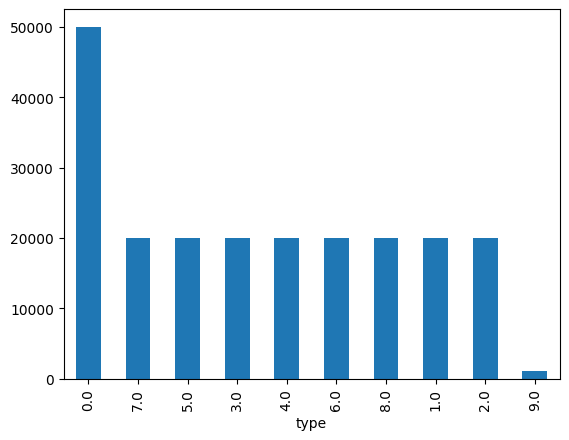

In [44]:
# plot how the data is balanced
data['type'].value_counts().plot(kind='bar')

In [45]:
data.head()

,type,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,...,src_pkts,dst_pkts,dns_query,dns_qtype,ssl_version,ssl_cipher,http_method,http_uri,http_status_code,weird_name
0,7.0,21.0,58720.0,212.0,587.0,0.0,0.0,0.000000,0.0,0.0,...,1.0,0.0,3.920578,0.0,3.462667,3.462667,0.0,3.459716,0.0,3.461917
1,0.0,13.0,1677.0,199.0,1677.0,0.0,0.0,0.215150,0.0,0.0,...,120.0,0.0,3.920578,0.0,3.462667,3.462667,0.0,3.459716,0.0,3.461917
2,7.0,20.0,42908.0,194.0,27353.0,0.0,0.0,0.007178,0.0,0.0,...,1.0,1.0,3.920578,0.0,3.462667,3.462667,0.0,3.459716,0.0,3.461917
3,5.0,20.0,33000.0,203.0,80.0,0.0,2.0,20.535570,3896.0,26489.0,...,25.0,41.0,3.920578,0.0,3.462667,3.462667,0.0,3.459716,0.0,3.461917
4,3.0,20.0,57.0,201.0,57.0,0.0,0.0,0.000006,0.0,0.0,...,2.0,2.0,3.920578,0.0,3.462667,3.462667,0.0,3.459716,0.0,3.461917


In [46]:
X = data.drop(columns = ['type'])
y = data['type']

In [47]:
def prepare_data(X, y, test_size=0.2, random_state=42):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

In [48]:
#prepare xgboost params
def train_xgboost(X_train, y_train, X_test, y_test):
    # Define model parameters
    params = {
        'objective': 'multi:softprob',  # multiclass classification
        'num_class': len(np.unique(y_train)),  # number of classes
        'learning_rate': 0.1,
        'max_depth': 6,
        'min_child_weight': 1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'tree_method': 'hist',  # faster training
        'random_state': 42
    }
    model = xgb.XGBClassifier(**params)
     # Train model with early stopping
    eval_set = [(X_train, y_train), (X_test, y_test)]
    model.fit(
        X_train, y_train,
        eval_set=eval_set,
        eval_metric=['mlogloss', 'merror'],
        early_stopping_rounds=20,
        verbose=True
    )
    
    return model

In [49]:
def plot_feature_importance(model, feature_names=None):
    importance = model.feature_importances_
    sorted_idx = np.argsort(importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    
    plt.figure(figsize=(12, 6))
    plt.barh(pos, importance[sorted_idx])
    plt.yticks(pos, feature_names[sorted_idx] if feature_names is not None 
               else [f'Feature {i}' for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('XGBoost Feature Importance')
    plt.show()

In [50]:
# Plot confusion matrix
def plot_confusion_matrix(conf_matrix, class_names=None):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else 'auto',
                yticklabels=class_names if class_names else 'auto')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    

In [51]:
def evaluate_model(model, model_name, X_test, y_test):
    # Make predictions
    y_pred = model.predict(X_test)
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Return the results along with the model name
    print(f"Results for {model_name}:")
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'classification_report': class_report,
        'confusion_matrix': conf_matrix,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }


In [52]:
def perform_cv(model, X, y, cv=5):
    # Define the scoring metrics
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
    
    # Perform cross-validation
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=False)
    
    # Print results for each metric
    print("\nCross-validation results for XGBoost Classifier:")
    print(f"Accuracy: {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std() * 2:.4f})")
    print(f"Precision: {cv_results['test_precision_weighted'].mean():.4f} (+/- {cv_results['test_precision_weighted'].std() * 2:.4f})")
    print(f"Recall: {cv_results['test_recall_weighted'].mean():.4f} (+/- {cv_results['test_recall_weighted'].std() * 2:.4f})")
    print(f"F1 Score: {cv_results['test_f1_weighted'].mean():.4f} (+/- {cv_results['test_f1_weighted'].std() * 2:.4f})")
    
    return cv_results


In [56]:
# Define the main training function
def main_training():
    # 1. Prepare the data
    print("Preparing data...")
    
    # Apply the encoders and split the data
    X_train_scaled, X_test_scaled, y_train, y_test, scaler = prepare_data(X, y)
    
    # 2. Train XGBoost Model
    print("\nTraining XGBoost Model...")
    xgb_model = train_xgboost(X_train_scaled, y_train, X_test_scaled, y_test)
    
    pipeline_components = {
        'scaler': scaler,
        'label_encoder_src_ip': le_src,
        'label_encoder_dst_ip': le_dst,
        'target_encoder': target_encoder,
        'model': xgb_model
    }

    # 3. Evaluate XGBoost Model
    print("\nEvaluating XGBoost Model...")
    xgb_results = evaluate_model(xgb_model, "XGBoost", X_test_scaled, y_test)
    print("\nXGBoost Metrics:")
    print(f"Precision: {xgb_results['precision']:.4f}")
    print(f"Recall: {xgb_results['recall']:.4f}")
    print(f"F1 Score: {xgb_results['f1_score']:.4f}")
    
    # 4. Perform Cross-Validation
    print("\nPerforming Cross-Validation for XGBoost Model...")
    cv_results = perform_cv(xgb_model, X_train_scaled, y_train, cv=5)
        
    # 5. Plot confusion matrix
    print("\nPlotting Confusion Matrix...")
    plt.figure(figsize=(5, 5))
    plot_confusion_matrix(xgb_results['confusion_matrix'])
    plt.title('XGBoost Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    # 6. Plot feature importance for XGBoost
    print("\nPlotting XGBoost Feature Importance...")
    plot_feature_importance(xgb_model, X.columns)
    
    # 7. Save the entire pipeline with encoders and trained model
    with open('/kaggle/working/pipeline.pkl', 'wb') as file:
        pk.dump(pipeline_components, file)
    print("Pipeline saved as 'network_analysis_pipeline.pkl'")
    
    # Return the model, its results, and CV results
    return {
        'xgboost': {
            'model': xgb_model,
            'results': xgb_results,
            'cv_results': cv_results
        }
    }


Preparing data...

Training XGBoost Model...
[0]	validation_0-mlogloss:1.84829	validation_0-merror:0.01779	validation_1-mlogloss:1.84784	validation_1-merror:0.01760
[1]	validation_0-mlogloss:1.55999	validation_0-merror:0.01365	validation_1-mlogloss:1.55966	validation_1-merror:0.01395
[2]	validation_0-mlogloss:1.34861	validation_0-merror:0.01192	validation_1-mlogloss:1.34863	validation_1-merror:0.01279
[3]	validation_0-mlogloss:1.18117	validation_0-merror:0.01122	validation_1-mlogloss:1.18139	validation_1-merror:0.01196
[4]	validation_0-mlogloss:1.04261	validation_0-merror:0.01055	validation_1-mlogloss:1.04308	validation_1-merror:0.01151
[5]	validation_0-mlogloss:0.92687	validation_0-merror:0.00998	validation_1-mlogloss:0.92749	validation_1-merror:0.01076
[6]	validation_0-mlogloss:0.82859	validation_0-merror:0.00994	validation_1-mlogloss:0.82935	validation_1-merror:0.01078
[7]	validation_0-mlogloss:0.74299	validation_0-merror:0.00973	validation_1-mlogloss:0.74392	validation_1-merror:0.0

<Figure size 500x500 with 0 Axes>

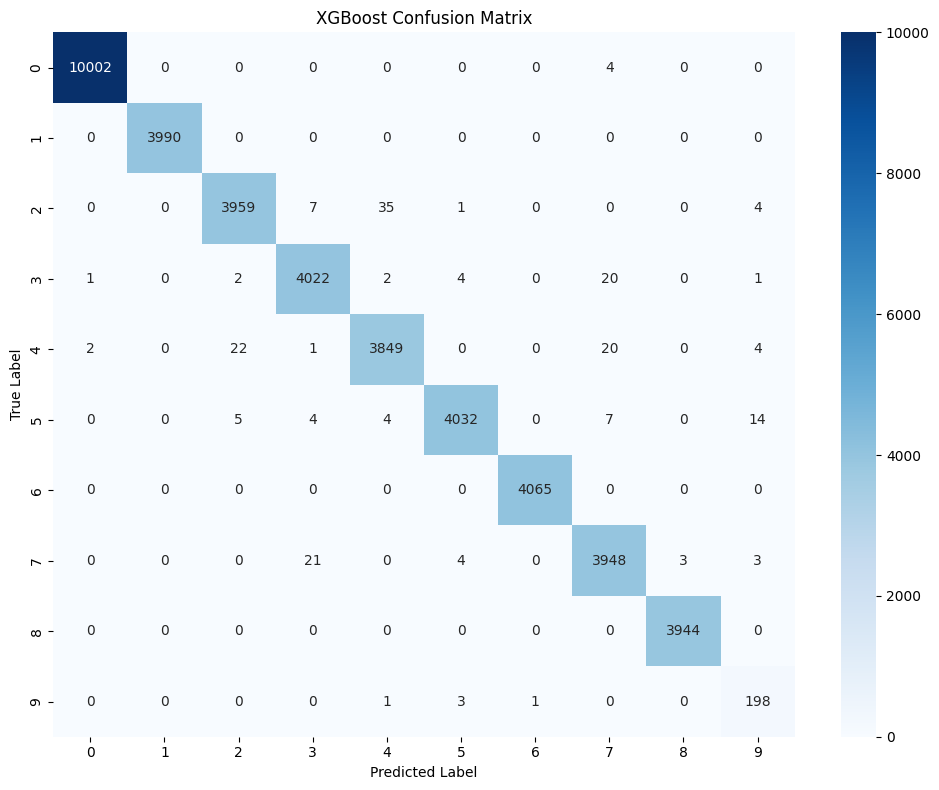


Plotting XGBoost Feature Importance...


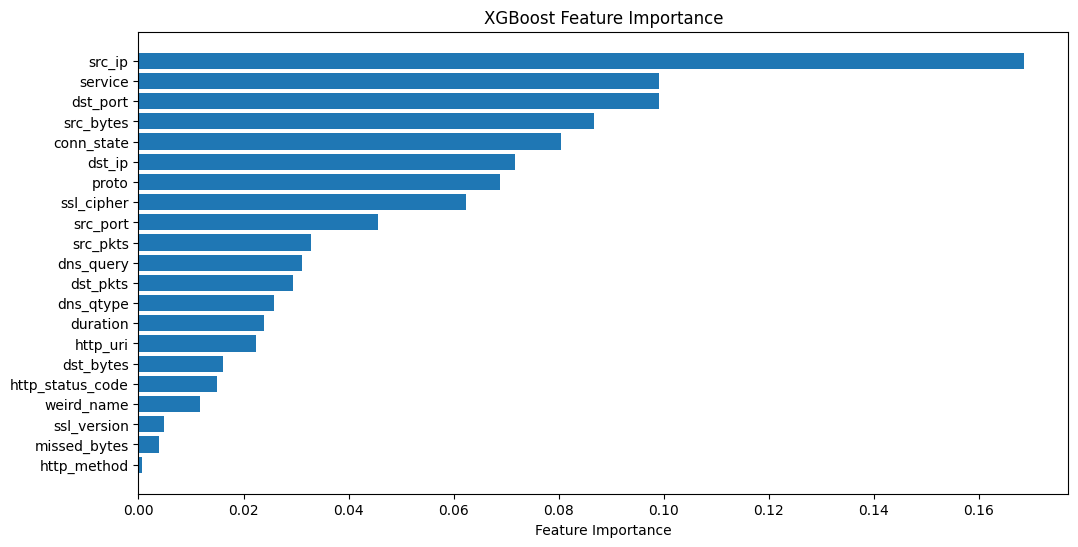

Pipeline saved as 'network_analysis_pipeline.pkl'


In [57]:
# Run the main function
if __name__ == "__main__":
    results = main_training()

In [58]:
print("execution complet...")

execution complet...
